In [1]:
!pip install tensorflow==2.15 keras==2.15 --upgrade

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [22]:
#Load the dataset
def load_data(filepath):
    df = pd.read_csv('/content/news.csv')
    # Drop the first column (index)
    df = df.drop(df.columns[0], axis=1)
    return df

In [23]:
# Text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

#Prepare the dataset
def prepare_data(df):
    # Preprocess text
    df['processed_text'] = df['text'].apply(preprocess_text)

    # Convert labels to binary (0 for FAKE, 1 for REAL)
    df['label'] = df['label'].apply(lambda x: 1 if x == 'REAL' else 0)

    return df

In [24]:
# Tokenization and sequence padding
def tokenize_and_pad(texts, max_words=10000, max_len=200):
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, truncating='post')
    return padded, tokenizer

In [25]:
# Build the model
def build_model(vocab_size, embedding_dim=64, max_len=200):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_len),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(24, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

    return model

In [43]:
# Plot training history
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['FAKE', 'REAL'],
                yticklabels=['FAKE', 'REAL'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Loading and preprocessing data...

Dataset Overview:
Total samples: 6335
FAKE news count: 3164
REAL news count: 3171

Sample data:
                                               title  label
0                       You Can Smell Hillary’s Fear      0
1  Watch The Exact Moment Paul Ryan Committed Pol...      0
2        Kerry to go to Paris in gesture of sympathy      1
3  Bernie supporters on Twitter erupt in anger ag...      0
4   The Battle of New York: Why This Primary Matters      1

Tokenizing and padding sequences...

Building model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           4280640   
                                                                 
 lstm_2 (LSTM)               (None, 200, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None,

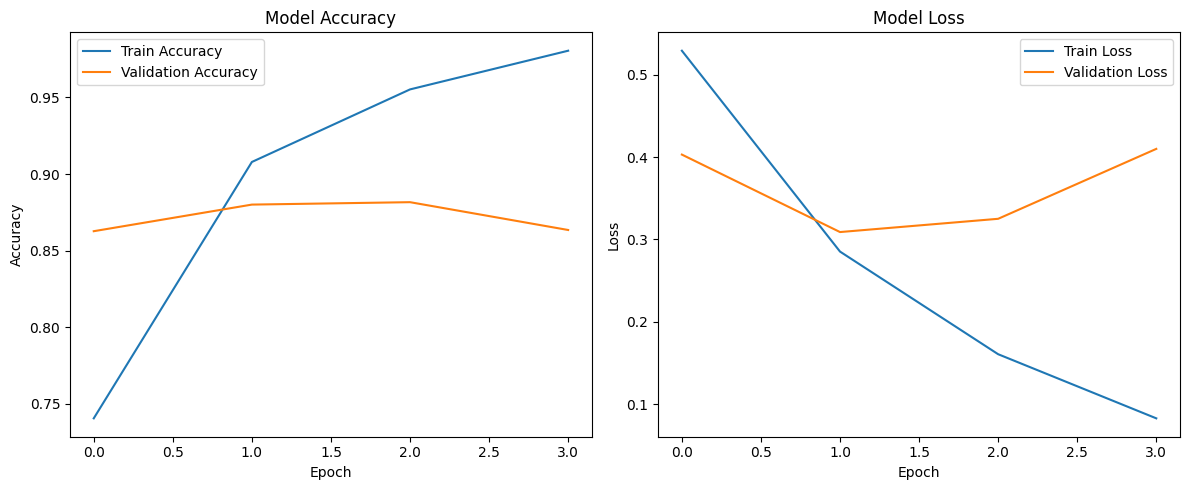


Evaluating model...
40/40 [==============================] - 3s 42ms/step

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.84      0.90      0.87       628
        REAL       0.89      0.83      0.86       639

    accuracy                           0.86      1267
   macro avg       0.87      0.86      0.86      1267
weighted avg       0.87      0.86      0.86      1267


Accuracy: 0.8635


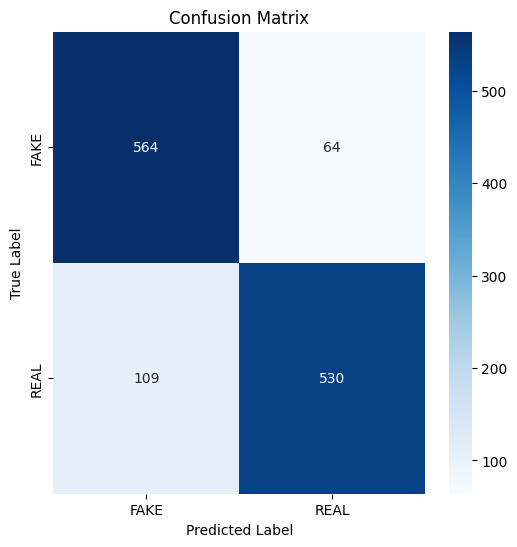

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Model and tokenizer saved successfully!


In [44]:
# Main function
def main():
    print("Loading and preprocessing data...")
    df = load_data('/content/news.csv')
    df = prepare_data(df)

    print("\nDataset Overview:")
    print(f"Total samples: {len(df)}")
    print(f"FAKE news count: {len(df[df['label'] == 0])}")
    print(f"REAL news count: {len(df[df['label'] == 1])}")
    print("\nSample data:")
    print(df[['title', 'label']].head())

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df['processed_text'], df['label'], test_size=0.2, random_state=42
    )

    print("\nTokenizing and padding sequences...")
    X_train_padded, tokenizer = tokenize_and_pad(X_train)
    X_test_padded = pad_sequences(
        tokenizer.texts_to_sequences(X_test),
        maxlen=200,
        truncating='post'
    )

    print("\nBuilding model...")
    vocab_size = len(tokenizer.word_index) + 1
    model = build_model(vocab_size)
    model.summary()

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=2)

    print("\nTraining model...")
    history = model.fit(
        X_train_padded, y_train,
        epochs=10,
        validation_data=(X_test_padded, y_test),
        callbacks=[early_stop],
        batch_size=32,
        verbose=1
    )

    # Plot training history
    plot_history(history)

    print("\nEvaluating model...")
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))
    print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    plot_confusion_matrix(y_test, y_pred)

    # Save model and tokenizer for future use
    model.save('news_classifier.h5')
    import pickle
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("\nModel and tokenizer saved successfully!")

if __name__ == "__main__":
    main()